### Loading the data 

the data has been cleaned and preprocessed and stored in the `solar_flux_data.csv`

In [1]:
import pandas as pd
df = pd.read_csv('solar_flux_data.csv')
df

,Date,sfu
0,1947-02-14,260.000000
1,1947-02-15,244.500000
2,1947-02-16,229.000000
3,1947-02-17,213.500000
4,1947-02-18,198.000000
...,...,...
26981,2020-12-28,85.983333
26982,2020-12-29,84.433333
26983,2020-12-30,83.583333
26984,2020-12-31,82.733333


converting the date column to date time to better handle the dates

In [2]:
df['Date'] = pd.to_datetime(df['Date'])

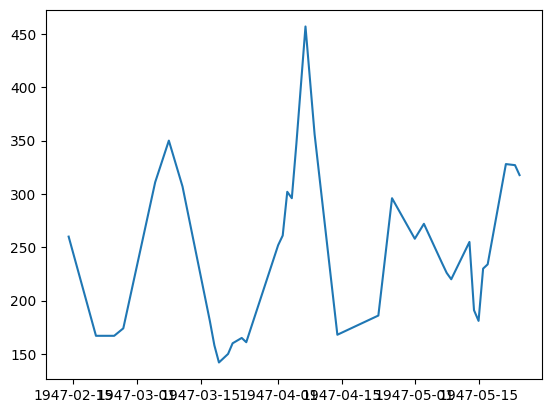

In [40]:
import matplotlib.pyplot as plt
num_of_entries = 100
plt.plot(df.head(num_of_entries)['Date'], df.head(num_of_entries)['sfu'])

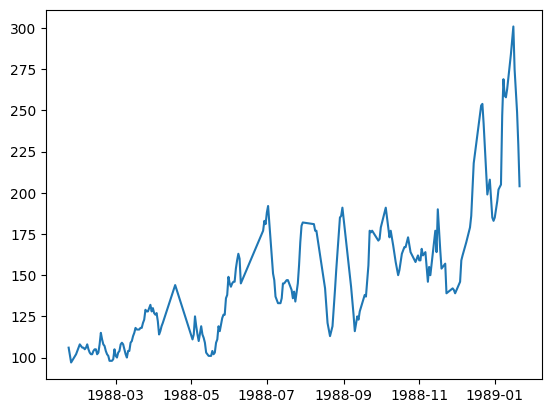

In [38]:
import matplotlib.pyplot as plt
import random
num_of_entries = 365
start = random.randint(0, len(df)- num_of_entries)
plt.plot(df['Date'][start: start+num_of_entries],df['sfu'][start: start+num_of_entries])

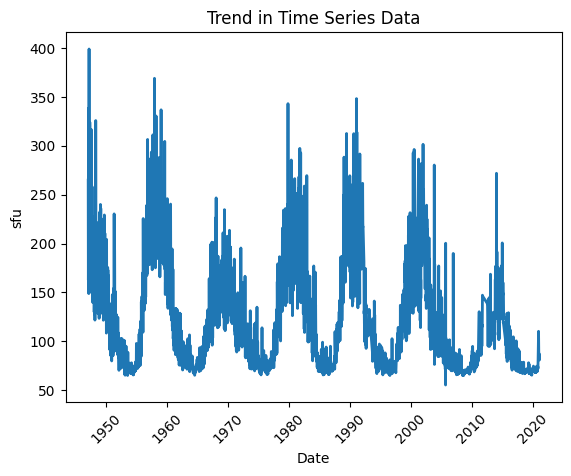

In [39]:
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

# Convert the 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Sort the DataFrame by the 'Date' column
df.sort_values(by='Date', inplace=True)

# Smoothing the data using Savitzky-Golay filter
window_size = 11
poly_order = 2
smoothed_values = savgol_filter(df['sfu'], window_size, poly_order)

# Plot the smoothed curve
plt.plot(df['Date'], smoothed_values, linewidth=2)

# Set the plot title and labels
plt.title("Trend in Time Series Data")
plt.xlabel("Date")
plt.ylabel("sfu")

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)

# Display the plot
plt.show()


## **MODEL 1 :  UNIVARIATE LSTM  MODEL**

### LAG: 27

In [41]:
import numpy as np
sequence = df['sfu']

def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

# define input sequence
raw_seq = df['sfu']
# choose a number of time steps
n_steps = 27
# split into samples
X, y = split_sequence(raw_seq, n_steps)
# summarize the data
# for i in range(len(X)):
# 	print(X[i], y[i])

In [42]:
X.shape

(26959, 27)

In [43]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [44]:
X_train

array([[260.        , 244.5       , 229.        , ..., 321.33333333,
        307.        , 286.        ],
       [244.5       , 229.        , 213.5       , ..., 307.        ,
        286.        , 265.        ],
       [229.        , 213.5       , 198.        , ..., 286.        ,
        265.        , 244.        ],
       ...,
       [ 76.81333333,  77.        ,  76.23333333, ...,  75.6       ,
         75.36666667,  73.93333333],
       [ 77.        ,  76.23333333,  75.56666667, ...,  75.36666667,
         73.93333333,  76.58888889],
       [ 76.23333333,  75.56666667,  75.        , ...,  73.93333333,
         76.58888889,  79.24444444]])

In [55]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train_transformed = scaler.fit_transform(X_train)
X_test_transformed = scaler.transform(X_test)

In [56]:
X_train_transformed

array([[0.5       , 0.4606599 , 0.4213198 , ..., 0.65566836, 0.61928934,
        0.56598985],
       [0.4606599 , 0.4213198 , 0.3819797 , ..., 0.61928934, 0.56598985,
        0.51269036],
       [0.4213198 , 0.3819797 , 0.34263959, ..., 0.56598985, 0.51269036,
        0.45939086],
       ...,
       [0.03505922, 0.03553299, 0.03358714, ..., 0.0319797 , 0.03138748,
        0.02774958],
       [0.03553299, 0.03358714, 0.03189509, ..., 0.03138748, 0.02774958,
        0.03448957],
       [0.03358714, 0.03189509, 0.03045685, ..., 0.02774958, 0.03448957,
        0.04122955]])

In [58]:
y_test

array([83.86666667, 85.83333333, 87.        , ..., 83.58333333,
       82.73333333, 82.73333333])

In [67]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint

n_features = 1
X_train_transformed = X_train_transformed.reshape((X_train_transformed.shape[0], X_train_transformed.shape[1], n_features))

# Define model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
model.add(Dense(1))

# Compile model with learning rate of 0.001
optimizer = Adam(lr=0.001)
model.compile(optimizer=optimizer, loss='mse')

# Define checkpoint callback
checkpoint = ModelCheckpoint('model_weights.h5', monitor='val_loss', save_best_only=True, save_weights_only=True)

# Fit model with checkpointing
history = model.fit(X_train_transformed, y_train, epochs=100, verbose=1, validation_data=(X_test_transformed, y_test), callbacks=[checkpoint])

Epoch 1/100
674/674 [==============================] - 8s 10ms/step - loss: 4697.8101 - val_loss: 134.9355
Epoch 2/100
674/674 [==============================] - 7s 10ms/step - loss: 636.9587 - val_loss: 130.5831
Epoch 3/100
674/674 [==============================] - 7s 10ms/step - loss: 608.8354 - val_loss: 132.4926
Epoch 4/100
674/674 [==============================] - 6s 9ms/step - loss: 584.2130 - val_loss: 115.2077
Epoch 5/100
674/674 [==============================] - 6s 9ms/step - loss: 508.9856 - val_loss: 106.5870
Epoch 6/100
674/674 [==============================] - 6s 9ms/step - loss: 456.3010 - val_loss: 90.3353
Epoch 7/100
674/674 [==============================] - 6s 9ms/step - loss: 346.4354 - val_loss: 140.7147
Epoch 8/100
674/674 [==============================] - 6s 9ms/step - loss: 340.9368 - val_loss: 104.6309
Epoch 9/100
674/674 [==============================] - 6s 9ms/step - loss: 263.2399 - val_loss: 66.1862
Epoch 10/100
674/674 [==============================]

In [68]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 50)                10400     
                                                                 
 dense_4 (Dense)             (None, 1)                 51        
                                                                 
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


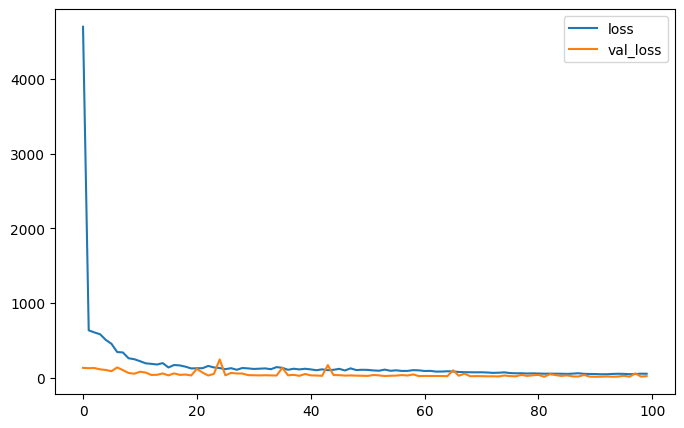

In [69]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.show()

In [70]:
number_of_dates = 100


dates = [df['Date'][i]  for  i in range(number_of_dates)]
observed = [y_test[i] for i in range(number_of_dates)]
predicted = [] 
for i in range(number_of_dates):
    
    x_input = X_test_transformed[i]
    x_input = x_input.reshape((1, n_steps, n_features))
    yhat = model.predict(x_input, verbose=0)
    # print(yhat, y_test[i])
    predicted.append(yhat[0][0])    
    

#  time  shifting the dates
predited_time_shifted = [predicted[i+1] for i in range(number_of_dates-1)]
observed_time_shifted = observed[:number_of_dates-1]

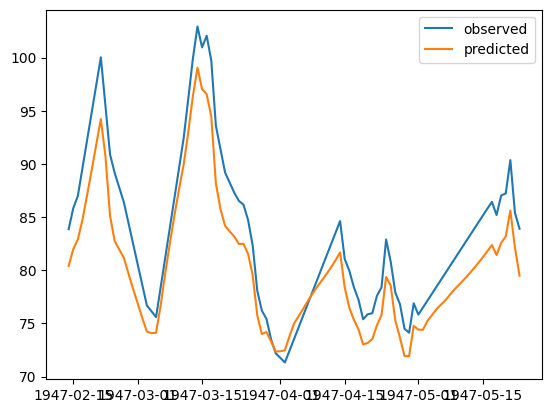

In [71]:
import matplotlib.pyplot as plt
plt.plot(dates[:number_of_dates-1], observed_time_shifted, label = "observed")
plt.plot(dates[:number_of_dates-1], predited_time_shifted, label = "predicted")
plt.legend()
plt.show()

In [72]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint

n_features = 1
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))

# Define model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
model.add(Dense(1))

# Compile model with learning rate of 0.001
optimizer = Adam(lr=0.001)
model.compile(optimizer=optimizer, loss='mse')

# Define checkpoint callback
checkpoint = ModelCheckpoint('model_weights2.h5', monitor='val_loss', save_best_only=True, save_weights_only=True)

# Fit model with checkpointing
history = model.fit(X_train, y_train, epochs=100, verbose=1, validation_data=(X_test, y_test), callbacks=[checkpoint])

Epoch 1/100
674/674 [==============================] - 8s 10ms/step - loss: 1478.8251 - val_loss: 36.7566
Epoch 2/100
674/674 [==============================] - 6s 9ms/step - loss: 137.4794 - val_loss: 27.5865
Epoch 3/100
674/674 [==============================] - 6s 10ms/step - loss: 111.8587 - val_loss: 28.9855
Epoch 4/100
674/674 [==============================] - 7s 10ms/step - loss: 98.2452 - val_loss: 20.4262
Epoch 5/100
674/674 [==============================] - 7s 10ms/step - loss: 77.8801 - val_loss: 22.5594
Epoch 6/100
674/674 [==============================] - 7s 10ms/step - loss: 68.0122 - val_loss: 20.4161
Epoch 7/100
674/674 [==============================] - 6s 9ms/step - loss: 295.2127 - val_loss: 27.0571
Epoch 8/100
674/674 [==============================] - 6s 9ms/step - loss: 80.3456 - val_loss: 19.3847
Epoch 9/100
674/674 [==============================] - 6s 9ms/step - loss: 64.6972 - val_loss: 16.8746
Epoch 10/100
674/674 [==============================] - 6s 9ms/

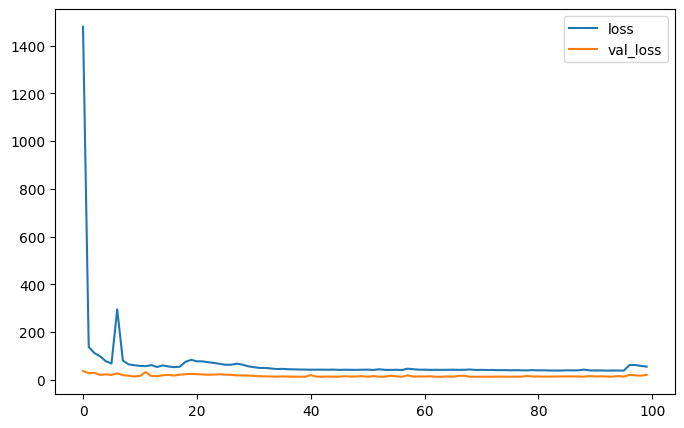

In [73]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.show()

In [78]:
number_of_dates = 500


dates = [df['Date'][i]  for  i in range(number_of_dates)]
observed = [y_test[i] for i in range(number_of_dates)]
predicted = [] 
for i in range(number_of_dates):
    
    x_input = X_test[i]
    x_input = x_input.reshape((1, n_steps, n_features))
    yhat = model.predict(x_input, verbose=0)
    # print(yhat, y_test[i])
    predicted.append(yhat[0][0])    
    

#  time  shifting the dates
predited_time_shifted = [predicted[i+1] for i in range(number_of_dates-1)]
observed_time_shifted = observed[:number_of_dates-1]

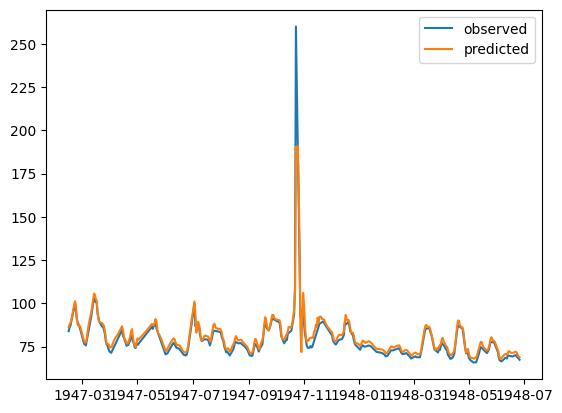

In [79]:
import matplotlib.pyplot as plt
plt.plot(dates[:number_of_dates-1], observed_time_shifted, label = "observed")
plt.plot(dates[:number_of_dates-1], predited_time_shifted, label = "predicted")
plt.legend()
plt.show()

looking at the metrics

multistep lstm prediction

In [1]:
import pandas as pd
df = pd.read_csv('solar_flux_data.csv')
df['Date'] = pd.to_datetime(df['Date'])
df

,Date,sfu
0,1947-02-14,260.000000
1,1947-02-15,244.500000
2,1947-02-16,229.000000
3,1947-02-17,213.500000
4,1947-02-18,198.000000
...,...,...
26981,2020-12-28,85.983333
26982,2020-12-29,84.433333
26983,2020-12-30,83.583333
26984,2020-12-31,82.733333


In [2]:
from numpy import array
def split_sequences(sequences, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out-1
		# check if we are beyond the dataset
		if out_end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1:out_end_ix, -1]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

In [ ]:
sequences = df['sfu']
n_steps_in = 7
steps_out = 7

In [7]:
X_train, y_train = [], []
for i in range(n_steps_in, len(sequences)-steps_out):
    X_train.append(sequences[i-n_steps_in:i])
    y_train.append(sequences[i: i+steps_out])

In [10]:
pd.DataFrame(X_train)

In [5]:
X, y = split_sequences(df['sfu'].to_numpy(), 27,3)

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed